In [21]:
import sys
import os
import matplotlib.pyplot as plt
import torch
# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

from models.bilstm.bilstm import BiLSTM
from src.models.data_management.bilstm_formes import BiLSTMFormesDataset
from src.data_processing.dataset_loader import CoastData
from src.models.metrics import Metrics

from src.models.data_management.data_loader import DataLoaderManager

import cv2

import numpy as np

In [26]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))

num_classes = 1
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

# Load the data to split it and save it to a dict
model = BiLSTM(num_classes=1, experiment_name="test_experiments", use_mlflow=False, pretrained=False)

model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-06-20-09-44-43_global_rgb/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_bilstm_global/"))

coast_data = CoastData(data_path, name="global")
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [27]:
print("Data loaded")
print(data["train"]['images'][0])

Data loaded
c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_bilstm_global\images\1555342200.Mon.Apr.15_16_30_00.CET.2019.agrelo.image.jpg


In [28]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)
    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

Split: train
train metrics: 
	train_accuracy: 0.953450083732605
	train_f1_score: 0.959844708442688
	train_precision: 0.9754641056060791
	train_recall: 0.9447176456451416
	train_confusion_matrix: 
		0.9660 0.0340
		0.0553 0.9447

Split: validation
val metrics: 
	val_accuracy: 0.9548693895339966
	val_f1_score: 0.9612261652946472
	val_precision: 0.9719802737236023
	val_recall: 0.9507075548171997
	val_confusion_matrix: 
		0.9608 0.0392
		0.0493 0.9507

Split: test
test metrics: 
	test_accuracy: 0.9512141942977905
	test_f1_score: 0.9579494595527649
	test_precision: 0.9740418195724487
	test_recall: 0.9423803091049194
	test_confusion_matrix: 
		0.9639 0.0361
		0.0576 0.9424



c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_bilstm_global\images\1533890026.Fri.Aug.10_09_33_46.CET.2018.cies.image.jpg


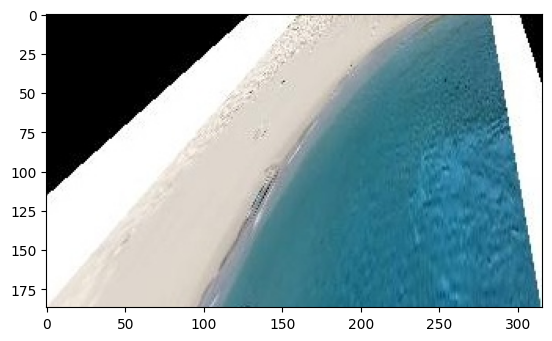

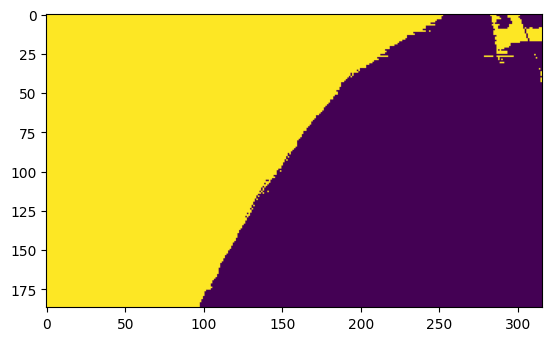

In [29]:
img_path = sorted(data['test']['images'])[1]
print(img_path)

pred = model.predict(img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

plt.imshow(pred.cpu())
plt.show()

# Save the results to an output folder

In [31]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_bilstm_global"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [32]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/SCLabels_prediction_bilstm_global/"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [33]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())

Split: train
Split: validation
Split: test


# Validation with differents models

In [36]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))

num_classes = 1
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

models_weights = {
    "agrelo": "2025-04-23-07-49-15_agrelo_rgb/models/best_model.pth",
    "cadiz": "2025-04-23-08-22-14_cadiz_rgb/models/best_model.pth",
    "cies": "2025-05-05-09-33-55_cies_rgb/models/best_model.pth",
    "arenaldentem": "2025-06-20-10-20-39_arenaldentem_rgb/models/best_model.pth",
    "samarador": "2025-06-20-10-51-17_samarador_rgb/models/best_model.pth",
}

# # Load the data to split it and save it to a dict
# model = BiLSTM(num_classes=1, experiment_name="test_experiments", use_mlflow=False, pretrained=False)
models = {model_name: BiLSTM(num_classes=1, experiment_name=model_name, use_mlflow=False, pretrained=False) for model_name in models_weights.keys()}

for model_name, model in models.items():
    print(f"Loading model {model_name}")
    model.load_model(os.path.abspath(os.path.join(artifact_path, models_weights[model_name])))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_bilstm_global/"))

coast_data = CoastData(data_path, name="global")
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

Loading model agrelo
Loading model cadiz
Loading model cies
Loading model arenaldentem
Loading model samarador
CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [20]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        model = models[img_path.split('_')[5].split('.')[3]]  # Get the model based on the split name
        
        pred = model.predict(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)
    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

Split: train
train metrics: 
	train_accuracy: 0.969430685043335
	train_f1_score: 0.9740473628044128
	train_precision: 0.9739829897880554
	train_recall: 0.9741116762161255
	train_confusion_matrix: 
		0.9627 0.0373
		0.0259 0.9741

Split: validation
val metrics: 
	val_accuracy: 0.9715191125869751
	val_f1_score: 0.9758894443511963
	val_precision: 0.9722398519515991
	val_recall: 0.9795664548873901
	val_confusion_matrix: 
		0.9600 0.0400
		0.0204 0.9796

Split: test
test metrics: 
	test_accuracy: 0.9686678051948547
	test_f1_score: 0.9735344052314758
	test_precision: 0.969810962677002
	test_recall: 0.977286696434021
	test_confusion_matrix: 
		0.9563 0.0437
		0.0227 0.9773



## Save the predictions

In [34]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_bilstm_global"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [37]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/SCLabels_prediction_bilstm_globa_by_set/"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [ ]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        model = models[img_path.split('_')[5].split('.')[3]]  # Get the model based on the split name
        pred = model.predict(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())

Split: train
Split: validation
Split: test


: 